# Análise dos dados para obter a resposta em frequêcia

Precisamos:

* selecionar o arquivo ulg com os dados,
* ajustar a janela de recorte de dados,
* selecionar o arquivo para guardar os dados para o processo de identificação de sistemas

No QGroundControl selecionamos o parâmetro SDLOG_PROFILE para o seguinte:

* Estimator Replay (EKF2)
* System Identification 
* High rate

In [1]:
import matplotlib
matplotlib.use('TkAgg')  # Configurar o backend para TkAgg
import matplotlib.pyplot as plt
%matplotlib inline
from pyulog import ULog
import numpy as np

In [3]:
# Função para ler o arquivo .ulg e extrair dados
def read_ulog(file_path):
    ulog = ULog(file_path)
    return ulog

# Função para listar todos os field_data de um arquivo .ulg
def list_all_fields(ulog):
    for dataset in ulog.data_list:
        topic_name = dataset.name
        print(f'Tópico: {topic_name}')
        for field_name in dataset.data.keys():
            if field_name != 'timestamp':  # Ignorar o campo de timestamp
                print(f'  Campo: {field_name}')

# Função para plotar os dados
def plot_ulog_data(ulog, topic_name, field_name):
    data = ulog.get_dataset(topic_name).data
    timestamps = data['timestamp'] / 1e6  # Convertendo de microssegundos para segundos
    field_data = data[field_name]

    plt.figure(figsize=(10, 5))
    plt.plot(timestamps, field_data, label=field_name)
    plt.xlabel('Tempo (s)')
    plt.ylabel(field_name)
    plt.title(f'{field_name} ao longo do tempo')
    plt.legend()
    plt.grid()
    plt.show()

def get_ulog_data(ulog, topic_name, field_name):
    data = ulog.get_dataset(topic_name).data
    timestamps = data['timestamp'] / 1e6  # Convertendo de microssegundos para segundos
    field_data = data[field_name]

    return timestamps, field_data

In [4]:
# Caminho para o arquivo .ulg
#file_path = 'ulogs/log_3_2024-9-2-16-13-55.ulg' # sweep signal OK!
file_path = 'ulogs/log_0_2024-9-2-17-20-09.ulg' # square signal Ok! Funciona bem para obter a resposta em frequência
#file_path = 'ulogs/log_1_2024-9-3-07-56-31.ulg' # double sawtooth signal 0k! Tem poucos harmônicos
#L er o arquivo .ulg
ulog = read_ulog(file_path)

In [5]:
# Listar todos os field_data
list_all_fields(ulog)

Tópico: actuator_motors
  Campo: timestamp_sample
  Campo: control[0]
  Campo: control[1]
  Campo: control[2]
  Campo: control[3]
  Campo: control[4]
  Campo: control[5]
  Campo: control[6]
  Campo: control[7]
  Campo: control[8]
  Campo: control[9]
  Campo: control[10]
  Campo: control[11]
  Campo: reversible_flags
Tópico: ekf2_timestamps
  Campo: airspeed_timestamp_rel
  Campo: distance_sensor_timestamp_rel
  Campo: optical_flow_timestamp_rel
  Campo: vehicle_air_data_timestamp_rel
  Campo: vehicle_magnetometer_timestamp_rel
  Campo: visual_odometry_timestamp_rel
Tópico: esc_status
  Campo: counter
  Campo: esc_count
  Campo: esc_connectiontype
  Campo: esc_online_flags
  Campo: esc_armed_flags
  Campo: _padding0[0]
  Campo: _padding0[1]
  Campo: esc[0].timestamp
  Campo: esc[0].esc_errorcount
  Campo: esc[0].esc_rpm
  Campo: esc[0].esc_voltage
  Campo: esc[0].esc_current
  Campo: esc[0].esc_temperature
  Campo: esc[0].failures
  Campo: esc[0].esc_address
  Campo: esc[0].esc_cmdcount

## Dados de entrada do experimento

É aplicada à atitude do veículo.

In [16]:
# coletar dados do sinal de entrada
timestamps_roll, roll   = get_ulog_data(ulog, 'vehicle_attitude_setpoint', 'roll_body')
timestamps_pitch, pitch = get_ulog_data(ulog, 'vehicle_attitude_setpoint', 'pitch_body')
timestamps_yaw, yaw     = get_ulog_data(ulog, 'vehicle_attitude_setpoint', 'yaw_body')

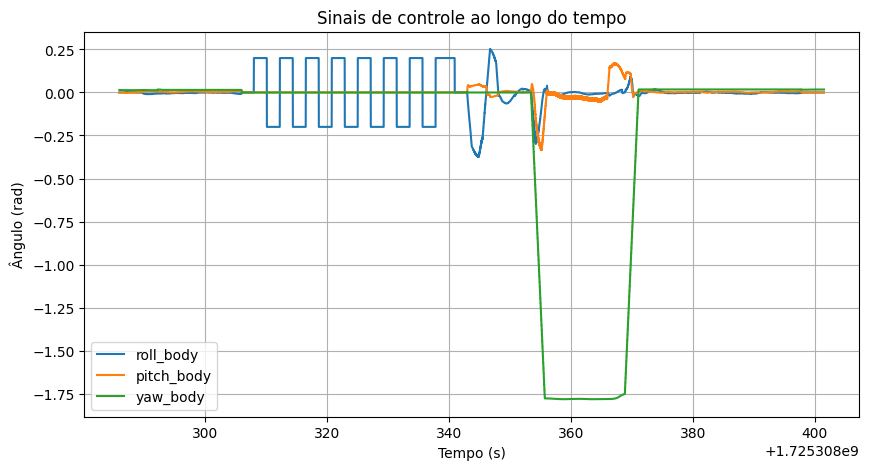

In [17]:
# Gerar os gráficos
plt.figure(figsize=(10, 5))
plt.plot(timestamps_roll, roll, label='roll_body')
plt.plot(timestamps_pitch, pitch, label='pitch_body')
plt.plot(timestamps_yaw, yaw, label='yaw_body')
plt.xlabel('Tempo (s)')
plt.ylabel('Ângulo (rad)')
plt.title('Sinais de entrada ao longo do tempo')
plt.legend()
plt.grid()
plt.show()

## Sinais dos motores e das taxas
Gerados indiretamente por meio da atitude desejada.

In [6]:
# Coletar os dados dos atuadores
timestamps_c0, control0 = get_ulog_data(ulog, 'actuator_motors', 'control[0]')
timestamps_c1, control1 = get_ulog_data(ulog, 'actuator_motors', 'control[1]')
timestamps_c2, control2 = get_ulog_data(ulog, 'actuator_motors', 'control[2]')
timestamps_c3, control3 = get_ulog_data(ulog, 'actuator_motors', 'control[3]')

# Coletar os dados das taxas de rotação
timestamps_vav0, vav0 = get_ulog_data(ulog, 'vehicle_angular_velocity', 'xyz[0]')
timestamps_vav1, vav1 = get_ulog_data(ulog, 'vehicle_angular_velocity', 'xyz[1]')
timestamps_vav2, vav2 = get_ulog_data(ulog, 'vehicle_angular_velocity', 'xyz[2]')

In [7]:
dt_controle = timestamps_c0[1] - timestamps_c0[0]  # Período de amostragem dos dados
t_controle = np.linspace(0, len(control0)*dt_controle, len(control0))  # Vetor de tempo
#
dt_taxas = timestamps_vav0[1] - timestamps_vav0[0]  # Período de amostragem dos dados
t_taxas = np.linspace(0, len(vav0)*dt_taxas, len(vav0))  # Vet

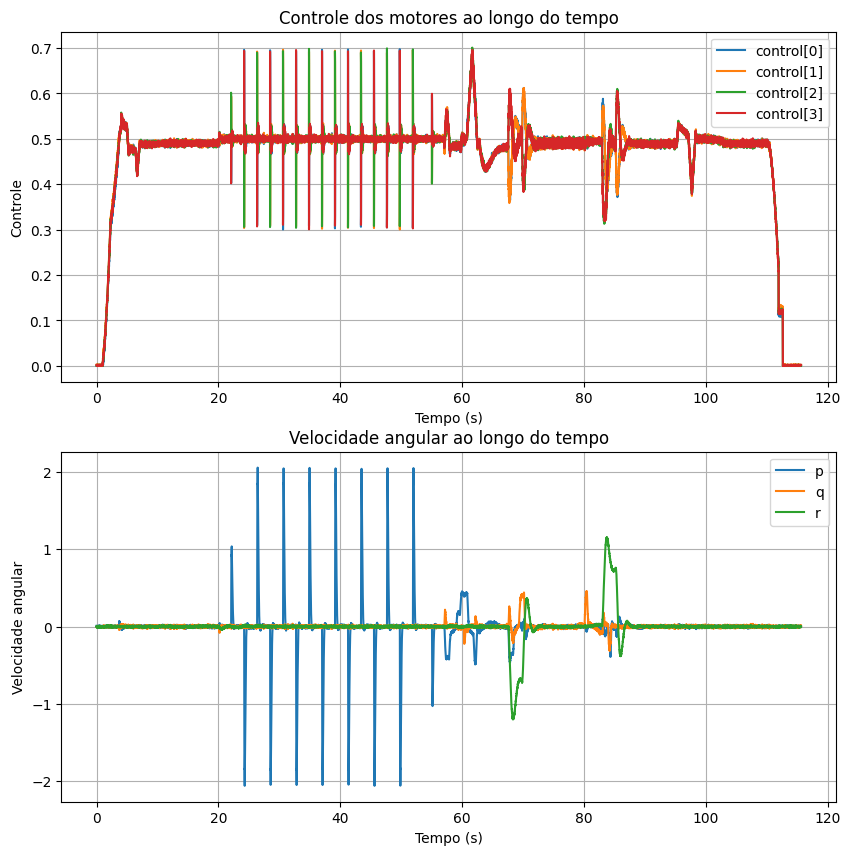

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
#
ax1.plot(t_controle, control0, label='control[0]')
ax1.plot(t_controle, control1, label='control[1]')
ax1.plot(t_controle, control2, label='control[2]')
ax1.plot(t_controle, control3, label='control[3]')
#
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle dos motores ao longo do tempo')
ax1.legend()
ax1.grid()
#
ax2.plot(t_taxas, vav0, label='p')
ax2.plot(t_taxas, vav1, label='q')
ax2.plot(t_taxas, vav2, label='r')
#
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade angular')
ax2.set_title('Velocidade angular ao longo do tempo')
ax2.legend()
ax2.grid()
#
#plt.tight_layout()
plt.show()
#  

## Recorte de sinais e ajuste do sinal de controle

* O sinal de controle é obtido da seguinte forma `'control[1] + control[2] - control[0] - control[3]'`.
* É tirada a média dos sinais de controle.
* Os sinais de controle e de taxa 'p' são filtrados com um filtro pasa baixas Butterworth de ordem 5.

In [9]:
# Recortando os dados para análise
t0_clip = 21.5
t1_clip = 56.5 #t0_clip + 15.0
#
t_cont_clipped = t_controle[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - t0_clip   # Recortando o vetor de tempo
controle0_clipped = control0[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control0[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) # Recortando o vetor de controle
controle1_clipped = control1[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control1[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) # Recortando o vetor de controle
controle2_clipped = control2[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control2[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) # Recortando o vetor de controle
controle3_clipped = control3[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control3[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) # Recortando o vetor de controle
# 
controle_clipped = controle1_clipped + controle2_clipped - controle0_clipped - controle3_clipped
# recortando as taxas de rotação
t_taxas_clipped = t_taxas[(t_taxas >= t0_clip) & (t_taxas <= t1_clip)] - t0_clip   # Recortando o vetor de tempo
vav0_clipped = vav0[(t_taxas >= t0_clip) & (t_taxas <= t1_clip)]  # Recortando as taxas de rotação
vav1_clipped = vav1[(t_taxas >= t0_clip) & (t_taxas <= t1_clip)]  # Recortando as taxas de rotação
vav2_clipped = vav2[(t_taxas >= t0_clip) & (t_taxas <= t1_clip)]  # Recortando as taxas de rotação

In [10]:
# Filtrando os dados
# filtrar sinal controle_clipped
from scipy.signal import butter, lfilter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

controle_clipped_filtered = butter_lowpass_filter(controle_clipped, 20, 1/dt_controle, order=5)
vav0_clipped_filtered = butter_lowpass_filter(vav0_clipped, 10, 1/dt_taxas, order=5)    

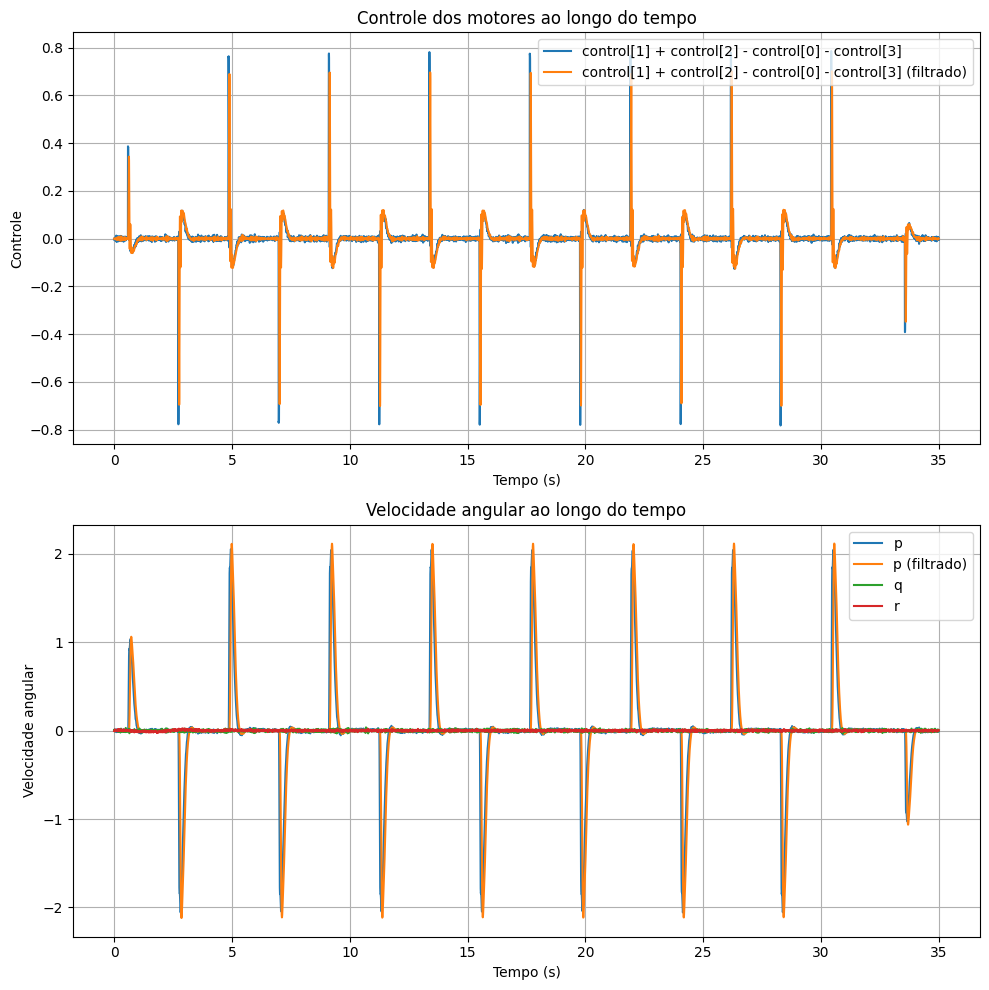

In [11]:
# Plotando os dados recortados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(t_cont_clipped, controle_clipped, label='control[1] + control[2] - control[0] - control[3]')
ax1.plot(t_cont_clipped, controle_clipped_filtered, label='control[1] + control[2] - control[0] - control[3] (filtrado)')
#ax1.plot(t_cont_clipped, controle0_clipped, label='control[0]')
#ax1.plot(t_cont_clipped, controle1_clipped, label='control[1]')
#ax1.plot(t_cont_clipped, controle2_clipped, label='control[2]')
#ax1.plot(t_cont_clipped, controle3_clipped, label='control[3]')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle dos motores ao longo do tempo')
ax1.legend()
ax1.grid()

ax2.plot(t_taxas_clipped, vav0_clipped, label='p')
ax2.plot(t_taxas_clipped, vav0_clipped_filtered, label='p (filtrado)')
ax2.plot(t_taxas_clipped, vav1_clipped, label='q')
ax2.plot(t_taxas_clipped, vav2_clipped, label='r')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade angular')
ax2.set_title('Velocidade angular ao longo do tempo')
ax2.legend()
ax2.grid()  
#
plt.tight_layout()
plt.show()

## Fast-Fourier Transform
É obtida a Transformada de Fourier unidirecional dos sinais.

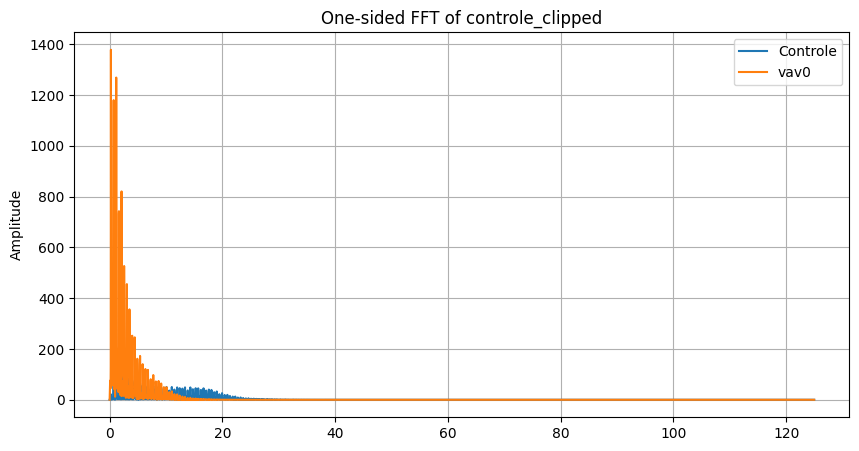

In [12]:
# One-side FFT de controle_clipped
fft_controle = np.fft.fft(controle_clipped_filtered)
freq = np.fft.fftfreq(len(controle_clipped_filtered), dt_controle)
fft_controle_one_sided = fft_controle[:len(fft_controle)//2]
freq_one_sided = freq[:len(freq)//2]

# One-side FFT de vav0_clipped
fft_vav0 = np.fft.fft(vav0_clipped_filtered)
freq_vav0 = np.fft.fftfreq(len(vav0_clipped_filtered), dt_taxas)
fft_vav0_one_sided = fft_vav0[:len(fft_vav0)//2]
freq_vav0_one_sided = freq_vav0[:len(freq_vav0)//2]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.plot(freq_one_sided, np.abs(fft_controle_one_sided))
ax1.plot(freq_vav0_one_sided, np.abs(fft_vav0_one_sided))
ax1.set_ylabel('Amplitude')
ax1.set_title('One-sided FFT of controle_clipped')

ax1.grid()
ax1.legend(['Controle', 'vav0'])
plt.show()

## Resposta em frequência
É obtida a resposta em freqência.

In [13]:
# calculate the magnitude of the FFT data
modulo = 20*np.log10(np.abs(fft_vav0_one_sided)/np.abs(fft_controle_one_sided))
# Calculate the phase angle of the FFT data
phase_controle = np.unwrap(np.angle(fft_controle_one_sided))
phase_vav0 = np.unwrap(np.angle(fft_vav0_one_sided))
fase = np.unwrap(phase_vav0 - phase_controle)

/tmp/ipykernel_540004/3673453414.py:4: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim([min(freq_one_sided), 10])
/tmp/ipykernel_540004/3673453414.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim([min(freq_one_sided), 10])


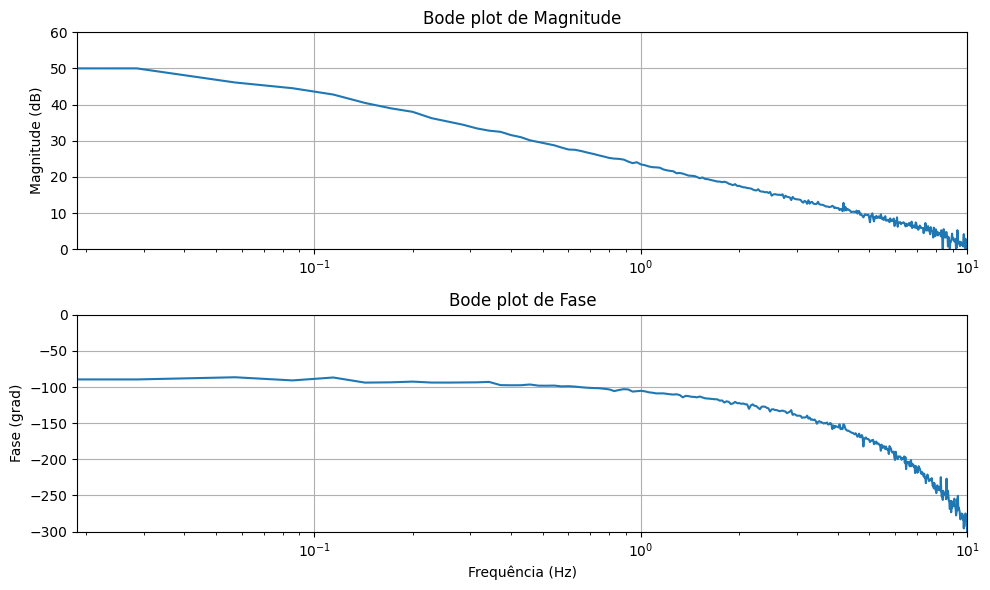

In [18]:
# Diagrama de Bode
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.semilogx(freq_one_sided, modulo)
ax1.set_xlim([min(freq_one_sided), 10])
ax1.set_ylim([0, 60])
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Bode plot de Magnitude')
ax1.grid()
ax2.semilogx(freq_one_sided, (fase*180/np.pi))
ax2.set_xlim([min(freq_one_sided), 10])
ax2.set_ylim([-300, 0])
ax2.set_xlabel('Frequência (Hz)')
ax2.set_ylabel('Fase (grad)')
ax2.set_title('Bode plot de Fase')
ax2.grid()
plt.tight_layout()
plt.show()

## Guarda os dados para análise posterior

In [19]:
# salvar os dados
# as frequencias, o modulo e a fase

#np.savetxt('freq_hz_p_rate.txt', freq_one_sided)
#np.savetxt('modulo_dB_p_rate.txt', modulo)
#np.savetxt('fase_rad_p_rate.txt', fase)